<a href="https://colab.research.google.com/github/georgsmeinung/rn1-perceptron/blob/main/RN-Clase01/RN-Practica01-05_Autos-Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Montar la carpeta de Google Drive y definir constantes para trabajar

In [1]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    from google.colab import drive
    drive.mount('/content/drive/')  # monta G-drive en entorno COLAB
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'  # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else: # entorno local # Rutas relativas al script para entornos locales Windows, WSL y Linux
    FUENTES_DIR = '../../FUENTES/'  # Ajusta según tu estructura
    DATOS_DIR = '../../DATOS/'

import sys
sys.path.append(FUENTES_DIR) # agrega ruta de busqueda donde tenemos archivos .py

Mounted at /content/drive/


### Importación de paquetes a utilzar

In [2]:
import pandas as pd
import numpy as np

from sklearn import model_selection, preprocessing, metrics
from ClassPerceptron import Perceptron  # importa clase preceptron de Laura

from matplotlib import pylab as plt
import seaborn as sns

### Carga de datos y numerización

In [3]:
# Leer los datos de entrenamiento y de testeo

df_train = pd.read_csv(DATOS_DIR+'automobile-simple.csv')


display(df_train.head(10))

,make,fuel-type,num-of-doors,body-style,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,price,volume,eco-rating
0,alfa-romero,gas,two,convertible,2548,130,111.0,21,27,13495.0,528019.904,33.297462
1,alfa-romero,gas,two,convertible,2548,130,111.0,21,27,16500.0,528019.904,33.297462
2,alfa-romero,gas,two,hatchback,2823,152,154.0,19,26,16500.0,587592.640,30.898272
3,audi,gas,four,sedan,2337,109,102.0,24,30,13950.0,634816.956,42.697819
4,audi,gas,four,sedan,2824,136,115.0,18,22,17450.0,636734.832,27.997459
5,audi,gas,two,sedan,2507,136,110.0,19,25,15250.0,624189.969,32.914278
6,audi,gas,four,sedan,2844,136,110.0,19,25,17710.0,766364.046,34.337685
7,audi,gas,four,wagon,2954,136,110.0,19,25,18920.0,766364.046,33.640553
8,audi,gas,four,sedan,3086,131,140.0,17,20,23875.0,769115.802,27.185014
9,audi,gas,two,hatchback,3053,131,160.0,16,22,NaN,629188.560,25.008890


### Matriz de Correlación

,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,price,volume,eco-rating
curb-weight,1.000000,0.850594,0.751034,-0.757414,-0.797465,0.834415,0.819806,-0.842111
engine-size,0.850594,1.000000,0.810773,-0.653658,-0.677470,0.872335,0.594351,-0.719602
horsepower,0.751034,0.810773,1.000000,-0.803620,-0.770908,0.810533,0.429840,-0.816182
city-mpg,-0.757414,-0.653658,-0.803620,1.000000,0.971337,-0.686571,-0.550292,0.977349
highway-mpg,-0.797465,-0.677470,-0.770908,0.971337,1.000000,-0.704692,-0.602410,0.983781
price,0.834415,0.872335,0.810533,-0.686571,-0.704692,1.000000,0.628701,-0.744017
volume,0.819806,0.594351,0.429840,-0.550292,-0.602410,0.628701,1.000000,-0.593856
eco-rating,-0.842111,-0.719602,-0.816182,0.977349,0.983781,-0.744017,-0.593856,1.000000


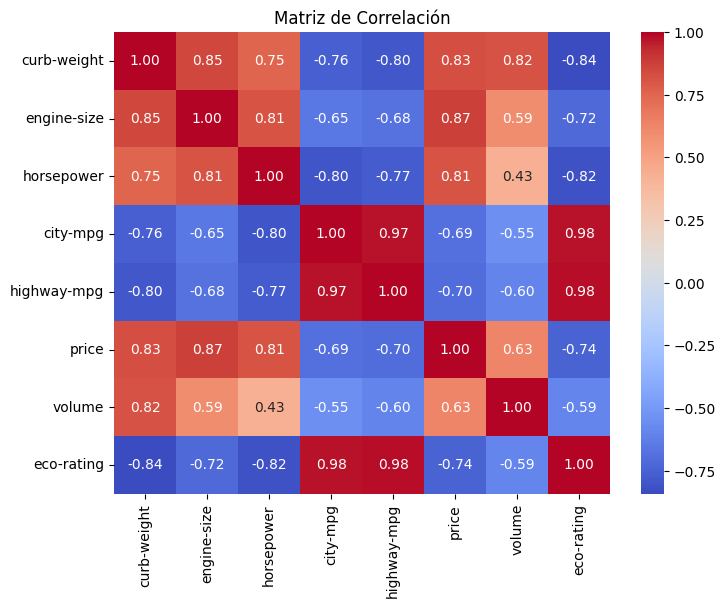

In [4]:
# Crear la matriz de correlación a partir se la selccion de datos numericos
correlation_matrix = df_train.select_dtypes(include='number').corr()

display(correlation_matrix)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(8, 6))

mapa_color = 'coolwarm' # 'cividis' 'viridis' 'plasma'
sns.heatmap(correlation_matrix, annot=True, cmap=mapa_color, fmt='.2f')
plt.title('Matriz de Correlación')

plt.show()

### Preparacion de Datos
Eliminacion de filas con valores nulos/blancos, selección de atributos numéricos, binarización de atributo **eco-rating** y normalización de atributos de entrenamiento.

In [5]:
# elimina filas con algún atributo nulo
df_train.dropna(inplace=True)

# Seleccionar solo las columnas numéricas
df_train = df_train.select_dtypes(include=[np.number])

print("\nDataFrame con solo valores numéricos:")
display(df_train)

# Define cuando un auto es ecologico a partir del coeficiente ecológico
# Si supera la media del atributo lo consideramos ecológico
T_train = df_train['eco-rating'] >= df_train['eco-rating'].mean()

# atributos para predecir (sin el coeficiente ecológico)
X_train = df_train.drop('eco-rating', axis=1)

normalizarEntrada = 1  # 1 si normaliza; 0 si no
if normalizarEntrada:
    if normalizarEntrada==1:  #--- Normalización lineal entre 0 y 1 ---
        normalizador = preprocessing.MinMaxScaler()
    else: # Normaliza utilizando la media y el desvio
        normalizador= preprocessing.StandardScaler()

    X_train = normalizador.fit_transform(X_train)


DataFrame con solo valores numéricos:


,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,price,volume,eco-rating
0,2548,130,111.0,21,27,13495.0,528019.904,33.297462
1,2548,130,111.0,21,27,16500.0,528019.904,33.297462
2,2823,152,154.0,19,26,16500.0,587592.640,30.898272
3,2337,109,102.0,24,30,13950.0,634816.956,42.697819
4,2824,136,115.0,18,22,17450.0,636734.832,27.997459
...,...,...,...,...,...,...,...,...
200,2952,141,114.0,23,28,16845.0,721961.760,38.354298
201,3049,141,160.0,19,25,19045.0,720913.920,32.043335
202,3012,173,134.0,18,23,21485.0,721961.760,29.806494
203,3217,145,106.0,26,27,22470.0,721961.760,35.073342


### Entrenamiento

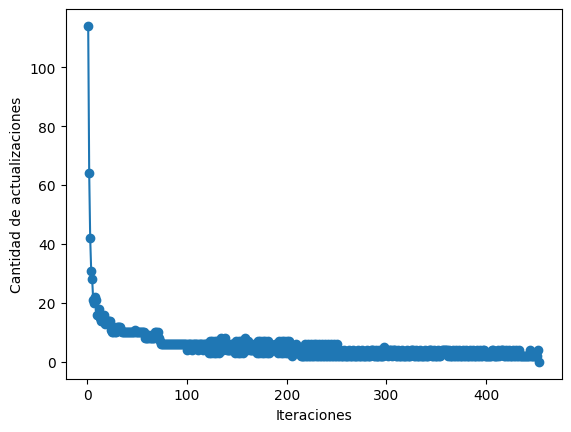

In [6]:
ppn = Perceptron(alpha=0.005, n_iter=650)
ppn.fit(X_train, T_train)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Iteraciones')
plt.ylabel('Cantidad de actualizaciones')
plt.show()

### Verificacion del Modelo

In [7]:
T_pred = ppn.predict(X_train)

# calculo manual de accuracy
aciertos = sum(T_train == T_pred)
print("nro aciertos = ", aciertos)
print("aciertos = %.2f %%" % (100*aciertos/X_train.shape[0]))

# Calculo con sklearn de accuracy
accuracy = metrics.accuracy_score(T_train, T_pred)
print("\nAccuracy: ", 100*accuracy, '%')

nro aciertos =  197
aciertos = 100.00 %

Accuracy:  100.0 %


### Matriz de Confusión y Metricas

In [8]:
MM = metrics.confusion_matrix(T_train, T_pred)
print("Matriz de confusión:\n%s" % MM)

report = metrics.classification_report(T_train, T_pred)
print("\nResultado de la clasificación:\n%s" % report)

Matriz de confusión:
[[104   0]
 [  0  93]]

Resultado de la clasificación:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       104
        True       1.00      1.00      1.00        93

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



In [12]:
# elimina filas con algún atributo nulo
df_train.dropna(inplace=True)

# Seleccionar solo las columnas numéricas
df_train = df_train.select_dtypes(include=[np.number])


# Define cuando un auto es ecologico a partir del coeficiente ecológico
# Si supera la media del atributo lo consideramos ecológico
T_train = df_train['eco-rating'] >= df_train['eco-rating'].mean()

# atributos para predecir (sin el coeficiente ecológico)
X_train = df_train[['curb-weight', 'engine-size', 'highway-mpg', 'volume']]

normalizarEntrada = 1  # 1 si normaliza; 0 si no
if normalizarEntrada:
    if normalizarEntrada==1:  #--- Normalización lineal entre 0 y 1 ---
        normalizador = preprocessing.MinMaxScaler()
    else: # Normaliza utilizando la media y el desvio
        normalizador= preprocessing.StandardScaler()

    X_train = normalizador.fit_transform(X_train)

print("\nDataFrame Normalizado con solo con “curb-weight”, “engine-size”, “highway-mpg”, “volumen”")
display(X_train)



DataFrame Normalizado con solo con “curb-weight”, “engine-size”, “highway-mpg”, “volumen”


array([[0.41117145, 0.26037736, 0.28947368, 0.19162062],
       [0.41117145, 0.26037736, 0.28947368, 0.19162062],
       [0.51784329, 0.34339623, 0.26315789, 0.34306472],
       [0.32932506, 0.18113208, 0.36842105, 0.46311703],
       [0.51823119, 0.28301887, 0.15789474, 0.4679926 ],
       [0.39526765, 0.28301887, 0.23684211, 0.43610141],
       [0.52598914, 0.28301887, 0.23684211, 0.79753228],
       [0.56865787, 0.28301887, 0.23684211, 0.79753228],
       [0.61986036, 0.26415094, 0.10526316, 0.80452772],
       [0.35182312, 0.17735849, 0.34210526, 0.43077704],
       [0.35182312, 0.17735849, 0.34210526, 0.43077704],
       [0.47401086, 0.38867925, 0.31578947, 0.43077704],
       [0.49534523, 0.38867925, 0.31578947, 0.43077704],
       [0.60783553, 0.38867925, 0.23684211, 0.63969477],
       [0.67571761, 0.55849057, 0.15789474, 0.63969477],
       [0.73390225, 0.55849057, 0.15789474, 0.64570193],
       [0.78238945, 0.55849057, 0.10526316, 0.84836286],
       [0.        , 0.        ,

### Entrenamientoº

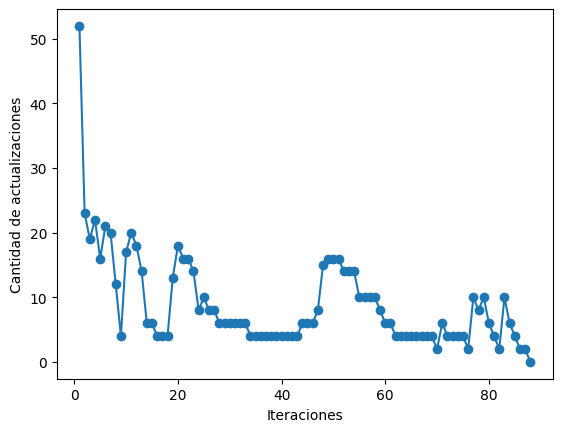

In [13]:
ppn = Perceptron(alpha=0.05, n_iter=100)
ppn.fit(X_train, T_train)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Iteraciones')
plt.ylabel('Cantidad de actualizaciones')
plt.show()

### Verificacion del Modelo

In [14]:
T_pred = ppn.predict(X_train)

# calculo manual de accuracy
aciertos = sum(T_train == T_pred)
print("nro aciertos = ", aciertos)
print("aciertos = %.2f %%" % (100*aciertos/X_train.shape[0]))

# Calculo con sklearn de accuracy
accuracy = metrics.accuracy_score(T_train, T_pred)
print("\nAccuracy: ", 100*accuracy, '%')

nro aciertos =  197
aciertos = 100.00 %

Accuracy:  100.0 %


### Matriz de Confusión y Metricas

In [15]:
MM = metrics.confusion_matrix(T_train, T_pred)
print("Matriz de confusión:\n%s" % MM)

report = metrics.classification_report(T_train, T_pred)
print("\nResultado de la clasificación:\n%s" % report)

Matriz de confusión:
[[104   0]
 [  0  93]]

Resultado de la clasificación:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       104
        True       1.00      1.00      1.00        93

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

